# Rectified Flow Inference

Load a checkpoint and sample using `rectified_flow_sample`.

In [1]:
from pathlib import Path
import sys
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.io import loadmat
import os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

TEXT_ENCODER_MODE = "llm"  # "clip" | "llm"
QWEN_MODEL_PATH = "/home/intern4/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B-Instruct/snapshots/7ae557604adf67be50417f59c2c2f167def9a775"
QWEN_LORA_PATH = "/home/intern4/fm2026/mrfm-intern/code_it_llm_ca/dapt/outputs/lora-0.5B/checkpoint-606"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

project_root = Path.cwd()
if project_root.name == 'visualize':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Clear Jupyter's argv to avoid argparse conflicts
if hasattr(sys, 'argv'):
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0]]


from datawrapper.datawrapper import _coerce_matlab_text, _normalize_tensor
from datawrapper.simple_tokenizer import SimpleTokenizer
from datawrapper.warpper_utils import interpolate_to_target_width, resize_512
from model.listfm_it import load_from_ckpt
from core_funcs import rectified_flow_sample
from common.metric import calculate_psnr, calculate_ssim

tokenizer = SimpleTokenizer()
qwen_tokenizer = None
if TEXT_ENCODER_MODE == "llm":
    from transformers import AutoTokenizer
    qwen_tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_PATH, use_fast=True)
    print("Qwen tokenizer loaded")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)


Qwen tokenizer loaded
device: cuda:0


In [2]:
data_root = Path("/fast_storage/intern/data/instruction_tuning/multi_task/acceleration_and_segmentation")
sample_path = data_root / "test"

In [84]:
run_idx = 28
run_ep = 8

# use best checkpoint for now
ckpt_path = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_{run_ep}.ckpt")

# sample_path = data_root

if TEXT_ENCODER_MODE == "llm":
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
        qwen_model_path=QWEN_MODEL_PATH,
        qwen_lora_path=None,
        qwen_trainable=False,
    )
    print("with Qwen LLM instruction encoder")
else:
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
    )

model = model.to(device)
model.eval()
print("loaded", ckpt_path)


2026-02-19 04:13:49 [SUCCESS] Checkpoint loaded successfully.
2026-02-19 04:13:49 [DEBUG] Width check success
2026-02-19 04:13:49 [DEBUG] Head check success
2026-02-19 04:13:49 [DEBUG] BPE file exists.
2026-02-19 04:13:51 [DEBUG] QC start.
2026-02-19 04:13:51 [DEBUG] Image size: torch.Size([2, 1, 512, 512])
2026-02-19 04:13:51 [DEBUG] Text size: torch.Size([2, 1536])
2026-02-19 04:13:55 [DEBUG] img_full_feature size: torch.Size([2, 1025, 512])
2026-02-19 04:13:55 [DEBUG] text_full_feature size: torch.Size([2, 1536, 512])
2026-02-19 04:13:55 [DEBUG] img mean std max min: 0.0754 1.0398 4.6759 -3.5423
2026-02-19 04:13:55 [DEBUG] text mean std max min: 0.0848 1.1799 25.7172 -15.0051
2026-02-19 04:13:55 [DEBUG] stack_feature[0] size: torch.Size([2, 64, 512, 512])
2026-02-19 04:13:55 [DEBUG] stack_feature[1] size: torch.Size([2, 128, 256, 256])
2026-02-19 04:13:55 [DEBUG] stack_feature[2] size: torch.Size([2, 256, 128, 128])
2026-02-19 04:13:55 [DEBUG] stack_feature[3] size: torch.Size([2, 5

Reduce aliasing in this T1 MRI slice without over-smoothing (R=6) after that locate the tumor area in this T1 MRI scan slice.
Mark the tumor location in this T2 brain MRI slice.
sample brats2023_gli_01509_t1_r6_s058_n01094.mat
instruction: Mark the tumor location in this T2 brain MRI slice.


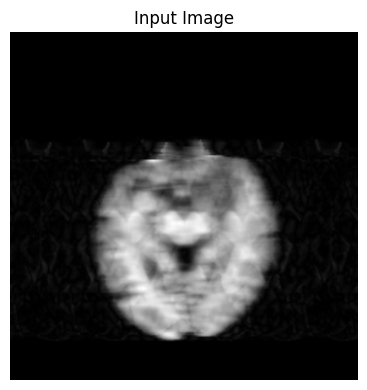

In [85]:
# Pick one sample
files = sorted(sample_path.glob("*.mat"))
assert files, f"no .mat files in {sample_path}"
mat_path = random.choice(files)
# mat_path = files[10]
data = loadmat(mat_path)

img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

img = interpolate_to_target_width(img, target_size=512)
img = resize_512(img)
label = resize_512(interpolate_to_target_width(label, target_size=512))

img = _normalize_tensor(img)
label = _normalize_tensor(label)

text_raw = _coerce_matlab_text(data["text"][0][0])
instr_raw = _coerce_matlab_text(data["instruction"][0][0])
print(instr_raw)
instr_raw = "Mark the tumor location in this T2 brain MRI slice."
text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
print(instr_raw)

instruction_llm_ids = None
instruction_llm_mask = None
if TEXT_ENCODER_MODE == "llm":
    llm_inputs = qwen_tokenizer(
        instr_raw,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    instruction_llm_ids = llm_inputs["input_ids"].squeeze(0)
    instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0)

instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0)

img = img.to(device)
label = label.to(device)
text = text.to(device)
instruction = instruction.to(device)
if TEXT_ENCODER_MODE == "llm":
    instruction_llm_ids = instruction_llm_ids.to(device).unsqueeze(0)
    instruction_llm_mask = instruction_llm_mask.to(device).unsqueeze(0)
else:
    instruction_llm_ids = torch.zeros(1, dtype=torch.long)
    instruction_llm_mask = (instruction != 0).to(torch.long)
label_2 = label.clone()
label_exp = label.clone()

print("sample", mat_path.name)
# print("text:", text_raw)
print("instruction:", instr_raw)
plt.figure(figsize=(6, 4))
plt.imshow(img[0, 0].cpu().numpy(), cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.tight_layout()
plt.show()


In [86]:
with torch.no_grad():
    llm_kwargs = {}
    if TEXT_ENCODER_MODE == "llm":
        llm_kwargs = {
            "instruction_llm_ids": instruction_llm_ids,
            "instruction_llm_mask": instruction_llm_mask,
        }
    # print(instruction)
    # print("llm_kwargs:", llm_kwargs)
    out = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, **llm_kwargs)
    # out_oneshot = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=1)

print("out shape:", tuple(out.shape))
print("label shape:", tuple(label.shape))


out shape: (1, 1, 512, 512)
label shape: (1, 1, 512, 512)


In [87]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Metric check (PSNR, SSIM, MSE)
psnr = calculate_psnr(label, out)
ssim = calculate_ssim(label, out)
print(f"psnr: {psnr.item():.2f}")
print(f"ssim: {ssim.item():.4f}")

# Convert tensors to numpy for scikit-image
out_np = out.squeeze().detach().cpu().numpy()
label_np = label.squeeze().detach().cpu().numpy()

# Calculate metrics using scikit-image
psnr_skimage = peak_signal_noise_ratio(label_np, out_np, data_range=label_np.max() - label_np.min())
ssim_skimage = structural_similarity(label_np, out_np, data_range=label_np.max() - label_np.min())

print(f"scikit-image psnr: {psnr_skimage:.2f}")
print(f"scikit-image ssim: {ssim_skimage: .4f}")
# psnr_oneshot = calculate_psnr(label, out_oneshot)
# ssim_oneshot = calculate_ssim(label, out_oneshot)
# print("oneshot psnr:", psnr_oneshot.item())
# print("oneshot ssim:", ssim_oneshot.item())

# mse = torch.mean((out.detach().cpu() - label.detach().cpu()) ** 2).item()
# print("mse:", mse)
# mse_oneshot = torch.mean((out_oneshot.detach().cpu() - label.detach().cpu()) ** 2).item()
# print("oneshot mse:", mse_oneshot)


psnr: 19.06
ssim: 0.8463
scikit-image psnr: 14.93
scikit-image ssim:  0.8755


input: (-0.5627834, 3.332769, 7.0780516e-08, 0.99999994)
out: (-0.13311394, 12.274235, 0.0061461143, 0.91883343)
label: (-0.13708477, 7.4901967, 4.0978193e-08, 1.0000002)


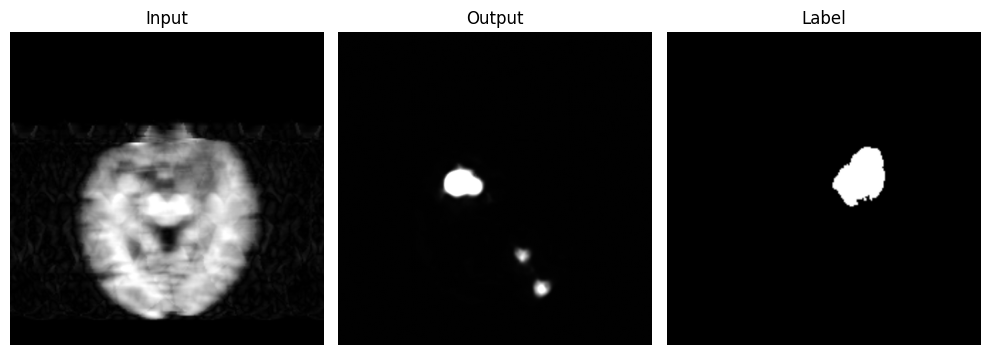

In [88]:
# plot input, output, label
input = img.squeeze().detach().cpu().numpy()
out = out.squeeze().detach().cpu().numpy()
label = label.squeeze().detach().cpu().numpy()
# out_oneshot = out_oneshot.squeeze().detach().cpu().numpy()

x1, x2, y1, y2 = 20, -20, 20, -20


print(f"input: {input.min(), input.max(), input.mean(), input.std()}")
print(f"out: {out.min(), out.max(), out.mean(), out.std()}")
print(f"label: {label.min(), label.max(), label.mean(), label.std()}")

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(label, 0.5)
vmax_out = np.percentile(label, 99.5)


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()

In [89]:
# Calculate PSNR and SSIM for cropped region using scikit-image, masking only brain region (exclude black background)
input_crop = input[x1:x2, y1:y2]
out_crop = out[x1:x2, y1:y2]
label_crop = label[x1:x2, y1:y2]

# Create a mask for the brain region (exclude background)
# Assume background is near zero, mask where label is above a threshold
mask = label_crop > (0.9 * label_crop.max())  # adjust threshold as needed

# Only compute metrics where mask is True
if mask.sum() > 0:
    psnr_skimage_masked = peak_signal_noise_ratio(label_crop[mask], out_crop[mask], data_range=label_crop.max() - label_crop.min())
    ssim_skimage_masked = structural_similarity(label_crop, out_crop, data_range=label_crop.max() - label_crop.min(), win_size=7, gaussian_weights=True, use_sample_covariance=False, mask=mask)
    print(f"Masked (brain only) scikit-image PSNR: {psnr_skimage_masked:.2f}")
    print(f"Masked (brain only) scikit-image SSIM: {ssim_skimage_masked:.4f}")
else:
    print("Mask is empty, cannot compute masked metrics.")

Masked (brain only) scikit-image PSNR: 0.06
Masked (brain only) scikit-image SSIM: 0.8654


False False
<class 'numpy.ndarray'> (512, 512)


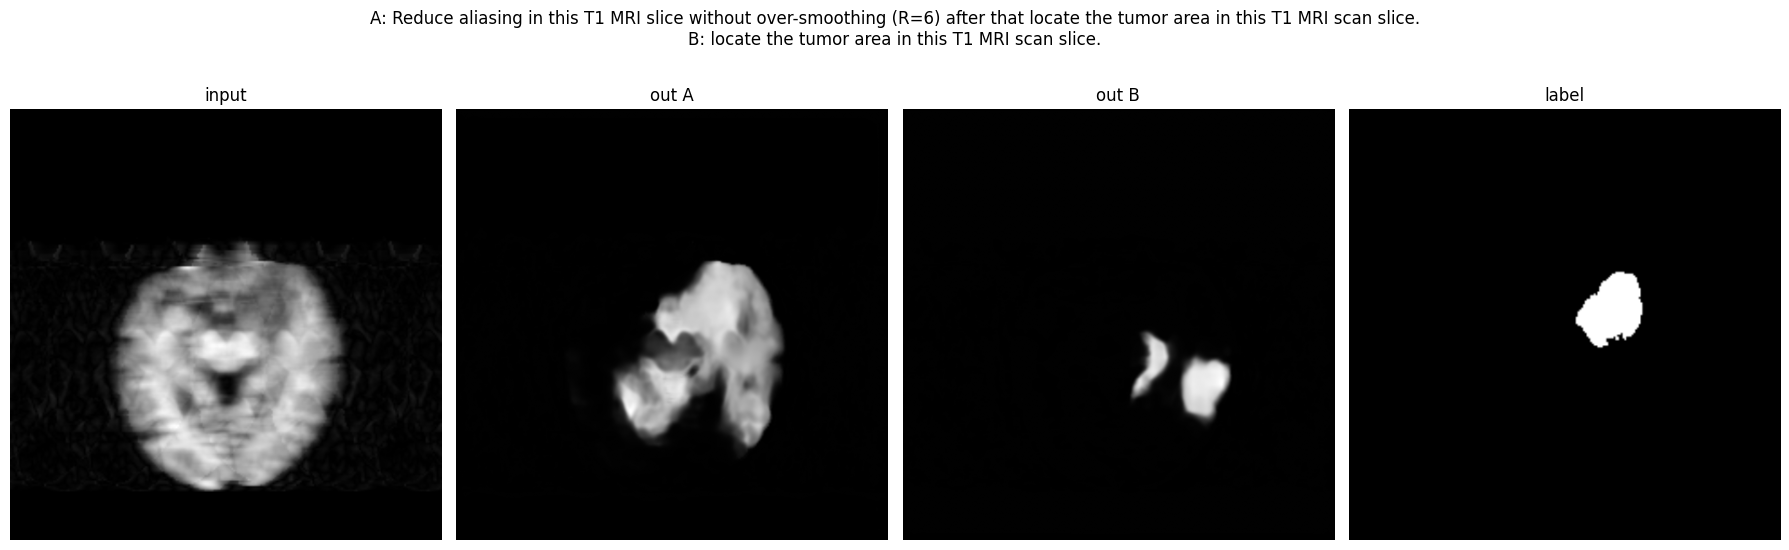

In [90]:
# Compare two instructions: outputs + diff map
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

instr_raw_a = "Reduce aliasing in this T1 MRI slice without over-smoothing (R=6) after that locate the tumor area in this T1 MRI scan slice."
instr_raw_b = "locate the tumor area in this T1 MRI scan slice."

def _make_instruction(instr_raw: str):
    instruction_llm_ids = None
    instruction_llm_mask = None
    if TEXT_ENCODER_MODE == "llm":
        llm_inputs = qwen_tokenizer(
            instr_raw,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        instruction_llm_ids = llm_inputs["input_ids"].squeeze(0).to(device).unsqueeze(0)
        instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0).to(device).unsqueeze(0)
        instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0).to(device)
    else:
        instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0).to(device)
    return instruction, instruction_llm_ids, instruction_llm_mask

with torch.no_grad():
    instr_a, llm_ids_a, llm_mask_a = _make_instruction(instr_raw_a)
    instr_b, llm_ids_b, llm_mask_b = _make_instruction(instr_raw_b)

    llm_kwargs_a = {}
    llm_kwargs_b = {}
    if TEXT_ENCODER_MODE == "llm":
        llm_kwargs_a = {"instruction_llm_ids": llm_ids_a, "instruction_llm_mask": llm_mask_a}
        llm_kwargs_b = {"instruction_llm_ids": llm_ids_b, "instruction_llm_mask": llm_mask_b}

    out_a = rectified_flow_sample(model=model, img=img, text=text, instruction=instr_a, **llm_kwargs_a)
    out_b = rectified_flow_sample(model=model, img=img, text=text, instruction=instr_b, **llm_kwargs_b)

print(torch.equal(llm_ids_a, llm_ids_b), torch.equal(instr_a, instr_b))


# visualize (center crop optional)
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes[0].imshow(img[0, 0].detach().cpu().numpy(), cmap="gray")
axes[0].set_title("input")
axes[0].axis("off")
axes[1].imshow(out_a[0, 0].detach().cpu().numpy(), cmap="gray")
axes[1].set_title("out A")
axes[1].axis("off")
axes[2].imshow(out_b[0, 0].detach().cpu().numpy(), cmap="gray")
axes[2].set_title("out B")
axes[2].axis("off")
print(type(label), label.shape)
axes[3].imshow(label, cmap="gray")
axes[3].set_title("label")
axes[3].axis("off")
plt.suptitle(f"A: {instr_raw_a}\nB: {instr_raw_b}")
plt.tight_layout()


In [ ]:
# Fix seed for fair A/B comparison (same noise)
def _set_seed(seed: int = 0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

_set_seed(42)


In [ ]:
# Quantify instruction impact
diff = (out_a - out_b).abs()
diff_mean = diff.mean().item()
diff_max = diff.max().item()
print(f"diff mean: {diff_mean:.6f}, diff max: {diff_max:.6f}")

# Optional: compare to label metrics if label exists
try:
    psnr_a = calculate_psnr(out_a, label).mean().item()
    psnr_b = calculate_psnr(out_b, label).mean().item()
    ssim_a = calculate_ssim(out_a, label).mean().item()
    ssim_b = calculate_ssim(out_b, label).mean().item()
    print(f"PSNR A/B: {psnr_a:.4f} / {psnr_b:.4f}")
    print(f"SSIM A/B: {ssim_a:.4f} / {ssim_b:.4f}")
except Exception as e:
    print("metric calc skipped:", e)


In [ ]:
# Diagnostic: check instruction token/feature differences
print('TEXT_ENCODER_MODE:', TEXT_ENCODER_MODE)
print('instr_raw_a:', instr_raw_a)
print('instr_raw_b:', instr_raw_b)

if TEXT_ENCODER_MODE != 'llm':
    ids_a = tokenizer.tokenize(instr_raw_a, context_length=64).squeeze()
    ids_b = tokenizer.tokenize(instr_raw_b, context_length=64).squeeze()
    print('token ids equal:', torch.equal(ids_a, ids_b))
    print('token overlap (nonzero):', (ids_a == ids_b).float().mean().item())

    with torch.no_grad():
        # instruction encoder output
        _, feat_a = model.instruction_encoder(text=ids_a.unsqueeze(0).to(device))
        _, feat_b = model.instruction_encoder(text=ids_b.unsqueeze(0).to(device))
    feat_diff = (feat_a - feat_b).abs().mean().item()
    feat_cos = torch.nn.functional.cosine_similarity(
        feat_a.flatten(1), feat_b.flatten(1), dim=1
    ).mean().item()
    print(f'inst feat mean abs diff: {feat_diff:.6f}, cosine sim: {feat_cos:.6f}')
else:
    # LLM mode
    llm_inputs_a = qwen_tokenizer(instr_raw_a, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    llm_inputs_b = qwen_tokenizer(instr_raw_b, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    ids_a = llm_inputs_a['input_ids'].squeeze(0)
    ids_b = llm_inputs_b['input_ids'].squeeze(0)
    mask_a = llm_inputs_a['attention_mask'].squeeze(0)
    mask_b = llm_inputs_b['attention_mask'].squeeze(0)
    
    print('LLM ids equal:', torch.equal(ids_a, ids_b))
    
    # Compare only non-padded tokens
    valid_mask = (mask_a * mask_b).bool()
    if valid_mask.sum() > 0:
        print('LLM token overlap (non-pad):', (ids_a[valid_mask] == ids_b[valid_mask]).float().mean().item())
        print(f'Valid tokens compared: {valid_mask.sum().item()}')
    else:
        print('LLM token overlap (non-pad): N/A (no valid tokens)')
    
    with torch.no_grad():
        _, feat_a = model.qwen_instruction_encoder(
            input_ids=ids_a.unsqueeze(0).to(device),
            attention_mask=llm_inputs_a['attention_mask'].to(device),
        )
        _, feat_b = model.qwen_instruction_encoder(
            input_ids=ids_b.unsqueeze(0).to(device),
            attention_mask=llm_inputs_b['attention_mask'].to(device),
        )
    
    # Compare features in non-pad regions only
    # Assuming feat_a/feat_b shape: [batch, seq_len, hidden_dim] or already pooled
    if feat_a.dim() == 3:  # sequence output [batch, seq_len, hidden_dim]
        # Expand masks to match feature dimensions
        mask_a_expanded = mask_a.unsqueeze(0).unsqueeze(-1).to(device)  # [1, seq_len, 1]
        mask_b_expanded = mask_b.unsqueeze(0).unsqueeze(-1).to(device)
        
        # Apply mask and compute mean over valid tokens
        feat_a_valid = (feat_a * mask_a_expanded).sum(dim=1) / mask_a_expanded.sum(dim=1).clamp(min=1)
        feat_b_valid = (feat_b * mask_b_expanded).sum(dim=1) / mask_b_expanded.sum(dim=1).clamp(min=1)
        
        feat_diff = (feat_a_valid - feat_b_valid).abs().mean().item()
        feat_cos = torch.nn.functional.cosine_similarity(
            feat_a_valid, feat_b_valid, dim=1
        ).mean().item()
    else:  # already pooled [batch, hidden_dim]
        feat_diff = (feat_a - feat_b).abs().mean().item()
        feat_cos = torch.nn.functional.cosine_similarity(
            feat_a.flatten(1), feat_b.flatten(1), dim=1
        ).mean().item()
    
    print(f'LLM inst feat mean abs diff (non-pad): {feat_diff:.6f}, cosine sim (non-pad): {feat_cos:.6f}')


In [ ]:
# Instruction ablation: zero out instruction embedding/tokens
with torch.no_grad():
    if TEXT_ENCODER_MODE == "llm":
        # Zero LLM ids/mask still yields some embedding, so use explicit zero mask
        instr_zero = torch.zeros((1, 64), dtype=torch.long, device=device)
        llm_kwargs_zero = {"instruction_llm_ids": llm_ids_a, "instruction_llm_mask": torch.zeros_like(llm_mask_a)}
    else:
        instr_zero = torch.zeros_like(instr_a)
        llm_kwargs_zero = {}

    out_zero = rectified_flow_sample(model=model, img=img, text=text, instruction=instr_zero, **llm_kwargs_zero)

diff_zero = (out_a - out_zero).abs()
print(f"A vs zero diff mean: {diff_zero.mean().item():.6f}, max: {diff_zero.max().item():.6f}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(out_a[0, 0].detach().cpu().numpy(), cmap="gray")
axes[0].set_title("out A")
axes[0].axis("off")
axes[1].imshow(out_zero[0, 0].detach().cpu().numpy(), cmap="gray")
axes[1].set_title("out zero")
axes[1].axis("off")
axes[2].imshow(diff_zero[0, 0].detach().cpu().numpy(), cmap="magma")
axes[2].set_title("|A - zero|")
axes[2].axis("off")
plt.tight_layout()


In [ ]:
# Inference All and Save as .mat
import json
from tqdm import tqdm
from scipy.io import savemat

import torch
device = torch.device("cuda:0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_idx = 1
run_ep = 4

# Create output directory
output_dir = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/inference/ep_{run_ep}")
output_dir.mkdir(parents=True, exist_ok=True)

files = sorted(sample_path.glob("*.mat"))
assert files, f"no .mat files in {sample_path}"
files = files[:10]

print(f"Processing {len(files)} samples...")
print(f"Output directory: {output_dir}")

results = []
model.eval()

with torch.no_grad():
    for idx, mat_path in enumerate(tqdm(files)):
        try:
            data = loadmat(mat_path)
            
            img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
            label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()
            
            img = interpolate_to_target_width(img, target_size=512)
            img = resize_512(img)
            label = resize_512(interpolate_to_target_width(label, target_size=512))
            
            img = _normalize_tensor(img)
            label = _normalize_tensor(label)
            
            text_raw = _coerce_matlab_text(data["text"][0][0])
            instr_raw = _coerce_matlab_text(data["instruction"][0][0])
            
            text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)

            instruction_llm_ids = None
            instruction_llm_mask = None
            if TEXT_ENCODER_MODE == "llm":
                llm_inputs = qwen_tokenizer(
                    instr_raw,
                    padding="max_length",
                    truncation=True,
                    max_length=128,
                    return_tensors="pt",
                )
                instruction_llm_ids = llm_inputs["input_ids"].squeeze(0)
                instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0)
                instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0)
            else:
                instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0)
            
            img = img.to(device)
            label = label.to(device)
            text = text.to(device)
            if TEXT_ENCODER_MODE == "llm":
                instruction_llm_ids = instruction_llm_ids.to(device).unsqueeze(0)
                instruction_llm_mask = instruction_llm_mask.to(device).unsqueeze(0)
                instruction = instruction.to(device)
            else:
                instruction = instruction.to(device)
            
            # Inference
            llm_kwargs = {}
            if TEXT_ENCODER_MODE == "llm":
                llm_kwargs = {
                    "instruction_llm_ids": instruction_llm_ids,
                    "instruction_llm_mask": instruction_llm_mask,
                }
            out = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, **llm_kwargs)
            
            # Calculate metrics
            psnr = calculate_psnr(label, out)
            ssim = calculate_ssim(label, out)
            mse = torch.mean((out.detach().cpu() - label.detach().cpu()) ** 2)
            
            # Convert to numpy
            img_np = img.squeeze().detach().cpu().numpy()
            out_np = out.squeeze().detach().cpu().numpy()
            label_np = label.squeeze().detach().cpu().numpy()
            
            # Save as .mat file
            out_mat_path = output_dir / f"{mat_path.stem}_result.mat"
            savemat(str(out_mat_path), {
                'input': img_np,
                'out': out_np,
                'label': label_np,
                'instruction': instr_raw,
                'psnr': psnr.item(),
                'ssim': ssim.item(),
                'mse': mse.item()
            })
            
            # Store metrics
            result = {
                "filename": mat_path.name,
                "stem": mat_path.stem,
                "psnr": psnr.item(),
                "ssim": ssim.item(),
                "mse": mse.item(),
                "instruction": instr_raw
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {mat_path.name}: {e}")
            continue

# Save summary metrics to JSON
summary = {
    "total_samples": len(results),
    "mean_psnr": np.mean([r["psnr"] for r in results]),
    "mean_ssim": np.mean([r["ssim"] for r in results]),
    "mean_mse": np.mean([r["mse"] for r in results]),
    "std_psnr": np.std([r["psnr"] for r in results]),
    "std_ssim": np.std([r["ssim"] for r in results]),
    "std_mse": np.std([r["mse"] for r in results]),
    "run_idx": run_idx,
    "run_ep": run_ep,
}

summary_path = output_dir / "summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

# Save detailed results
results_path = output_dir / "detailed_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nInference complete!")
print(f"Mean PSNR: {summary['mean_psnr']:.2f} +/- {summary['std_psnr']:.2f}")
print(f"Mean SSIM: {summary['mean_ssim']:.4f} +/- {summary['std_ssim']:.4f}")
print(f"Mean MSE: {summary['mean_mse']:.6f} +/- {summary['std_mse']:.6f}")
print(f"Results saved to: {output_dir}")


In [ ]:
log_root = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/inference/ep_{run_ep}")
res_files = sorted(log_root.glob("*_result.mat"))
print(f"Found {len(res_files)} result files")

In [ ]:
idx = 0

In [ ]:
idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input_img = res_mat["input"].squeeze()
output_img = res_mat["out"].squeeze()
label_img = res_mat["label"].squeeze()
instruction = res_mat["instruction"]

x1, x2, y1, y2 = 20, -20, 20, -20

vmin_input = np.percentile(input_img, 0.5)
vmax_input = np.percentile(input_img, 99.5)
vmin_out = np.percentile(output_img, 0.5)
vmax_out = np.percentile(output_img, 99.5)
vmin_label = np.percentile(label_img, 0.5)
vmax_label = np.percentile(label_img, 99.5)

plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.imshow(input_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(output_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(label_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_label, vmax=vmax_label)
plt.title("Label")
plt.axis("off")
plt.subplot(1, 4, 4)
diff = np.abs(output_img[x1:x2, y1:y2] - label_img[x1:x2, y1:y2])
print(output_img.shape, input_img.shape, diff.shape)
plt.imshow(diff, cmap="hot")
plt.colorbar()
plt.title("Output-Label Difference")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
label_exp_temp = label_exp.clone()

# Experiment: tweak steps and time scheduling
def make_t_schedule(steps, schedule="linear", device=None):
    if schedule == "linear":
        t_vals = torch.linspace(0.0, 1.0, steps + 1, device=device)
    elif schedule == "cosine":
        s = torch.linspace(0.0, 1.0, steps + 1, device=device)
        t_vals = 0.5 - 0.5 * torch.cos(torch.pi * s)
    elif schedule == "sigmoid":
        s = torch.linspace(-4.0, 4.0, steps + 1, device=device)
        t_vals = torch.sigmoid(s)
    else:
        raise ValueError(f"unknown schedule: {schedule}")
    return t_vals

def rectified_flow_sample_sched(model, img, text, instruction, steps=10, schedule="linear", t_eps=1e-4, instruction_llm_ids=None, instruction_llm_mask=None):
    t_vals = make_t_schedule(steps, schedule=schedule, device=img.device)
    z = torch.randn_like(img)
    for i in range(steps):
        t = t_vals[i].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        t_next = t_vals[i + 1].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        x_pred = model.forward(
            img=img,
            text=text,
            use_bottleneck=True,
            grad_encoder=True,
            instruction=instruction,
            instruction_llm_ids=instruction_llm_ids,
            instruction_llm_mask=instruction_llm_mask,
            flow_xt=z,
            flow_t=t.view(img.shape[0], 1),
        )
        denom = (1.0 - t).clamp_min(t_eps)
        v_pred = (x_pred - z) / denom
        z = z + (t_next - t) * v_pred
    return z

steps = 10
schedule = "linear"  # linear | cosine | sigmoid
t_eps = 1e-4

llm_kwargs = {}
if TEXT_ENCODER_MODE == "llm":
    llm_kwargs = {
        "instruction_llm_ids": instruction_llm_ids,
        "instruction_llm_mask": instruction_llm_mask,
    }

with torch.no_grad():
    out_exp = rectified_flow_sample_sched(model, img, text, instruction, steps=steps, schedule=schedule, t_eps=t_eps, **llm_kwargs)

print("steps", steps, "schedule", schedule, "t_eps", t_eps)
print("out shape:", tuple(out_exp.shape))
print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())


In [ ]:
# for steps in [10, 20, 40]:
#     for schedule in ["linear", "cosine", "sigmoid"]:
#         t_eps = 1e-4

#         with torch.no_grad():
#             out_exp = rectified_flow_sample_sched(model, img, text, instruction, steps=steps, schedule=schedule, t_eps=t_eps)
        
#         print("steps", steps, "schedule", schedule, "t_eps", t_eps)
#         print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())

In [ ]:
# # Full-step vs one-shot metrics on test split
# test_root = data_root / "test"
# test_files = sorted(test_root.glob("*.mat"))
# if len(test_files) > 100:
#     test_files = test_files[:100] # limit to 100 samples for quicker testing
# print("test files:", len(test_files))

# full_steps = None  # None uses rectified_flow_sample default
# max_samples = None  # set to an int to limit runtime
# psnr_full_vals = []
# ssim_full_vals = []
# mse_full_vals = []
# psnr_one_vals = []
# ssim_one_vals = []
# mse_one_vals = []

# model.eval()
# with torch.no_grad():
#     for idx, mat_path in enumerate(test_files):
#         if max_samples is not None and idx >= max_samples:
#             break
#         data = loadmat(mat_path)

#         img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
#         label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

#         img = interpolate_to_target_width(img, target_size=512)
#         img = resize_512(img)
#         label = resize_512(interpolate_to_target_width(label, target_size=512))

#         img = _normalize_tensor(img)
#         label = _normalize_tensor(label)

#         text_raw = _coerce_matlab_text(data["text"][0][0])
#         instr_raw = _coerce_matlab_text(data["instruction"][0][0])

#         text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
#         instruction = tokenizer.tokenize(instr_raw, context_length=1536).squeeze().unsqueeze(0)

#         img = img.to(device)
#         label = label.to(device)
#         text = text.to(device)
#         instruction = instruction.to(device)

#         if full_steps is None:
#             out_full = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction)
#         else:
#             out_full = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=full_steps)
#         out_oneshot = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=1)

#         psnr_full = calculate_psnr(out_full, label)
#         ssim_full = calculate_ssim(out_full, label)
#         mse_full = torch.mean((out_full - label) ** 2)

#         psnr_one = calculate_psnr(out_oneshot, label)
#         ssim_one = calculate_ssim(out_oneshot, label)
#         mse_one = torch.mean((out_oneshot - label) ** 2)

#         psnr_full_vals.append(psnr_full.item())
#         ssim_full_vals.append(ssim_full.item())
#         mse_full_vals.append(mse_full.item())
#         psnr_one_vals.append(psnr_one.item())
#         ssim_one_vals.append(ssim_one.item())
#         mse_one_vals.append(mse_one.item())

#         if (idx + 1) % 20 == 0:
#             print("processed", idx + 1)

# if psnr_full_vals:
#     print(f"full-step PSNR: {np.mean(psnr_full_vals):.2f} +/- {np.std(psnr_full_vals):.2f}")
#     print(f"one-shot PSNR: {np.mean(psnr_one_vals):.2f} +/- {np.std(psnr_one_vals):.2f}")
#     print(f"delta PSNR (full - one): {np.mean(np.array(psnr_full_vals) - np.array(psnr_one_vals)):.2f}")
#     print(f"full-step SSIM: {np.mean(ssim_full_vals):.4f} +/- {np.std(ssim_full_vals):.4f}")
#     print(f"one-shot SSIM: {np.mean(ssim_one_vals):.4f} +/- {np.std(ssim_one_vals):.4f}")
#     print(f"delta SSIM (full - one): {np.mean(np.array(ssim_full_vals) - np.array(ssim_one_vals)):.4f}")
#     print(f"full-step MSE: {np.mean(mse_full_vals):.6f} +/- {np.std(mse_full_vals):.6f}")
#     print(f"one-shot MSE: {np.mean(mse_one_vals):.6f} +/- {np.std(mse_one_vals):.6f}")
#     print(f"delta MSE (full - one): {np.mean(np.array(mse_full_vals) - np.array(mse_one_vals)):.6f}")
# else:
#     print("no test samples found in", test_root)
